# Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools

from sklearn.metrics import  silhouette_score
from sklearn.cluster import KMeans
import src.SI as SI

# Import data

In [3]:
data_DiCA = pd.read_csv('data/speeches/DiCA_encoding.csv', index_col=0)

In [4]:
data_DiCA.head()

,fileID,Dim1,Dim2,Dim3,Dim4,lang4
1,EN_NL_273,-0.294789,0.386800,-1.143248,-0.179576,Eng_Dut
2,EN_NL_274,-1.114812,0.548017,-1.455429,-0.293491,Eng_Dut
3,EN_NL_275,0.129165,-0.005245,-0.506319,-0.321190,Eng_Dut
4,EN_NL_276,0.000329,0.378454,-0.185255,-0.303848,Eng_Dut
5,EN_NL_277,-0.062971,0.350621,-0.442865,-0.193787,Eng_Dut


# Take a look at the ground truth

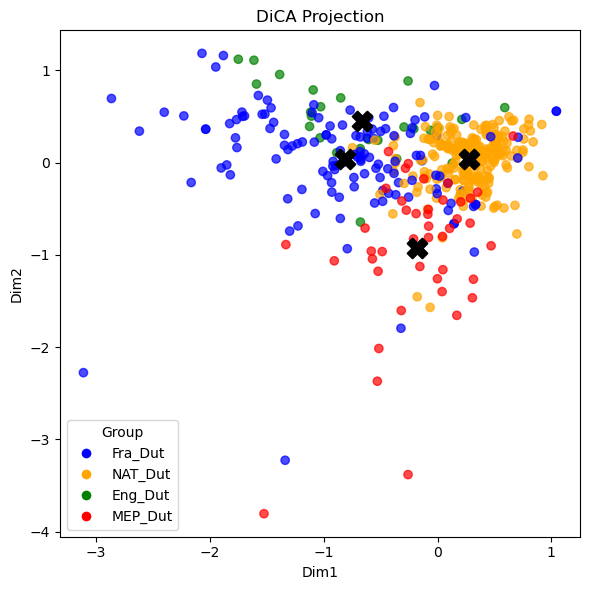

In [5]:

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plot_dica_projection(axs, data=data_DiCA)

plt.tight_layout()
plt.show()

In [6]:
results_DiCA = {}
data_DiCA_coords = data_DiCA.drop(columns=["lang4", "fileID"]).values  # shape: (n_cells, 4)

# Apply Kmeans and visually compare

c:\Users\Victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


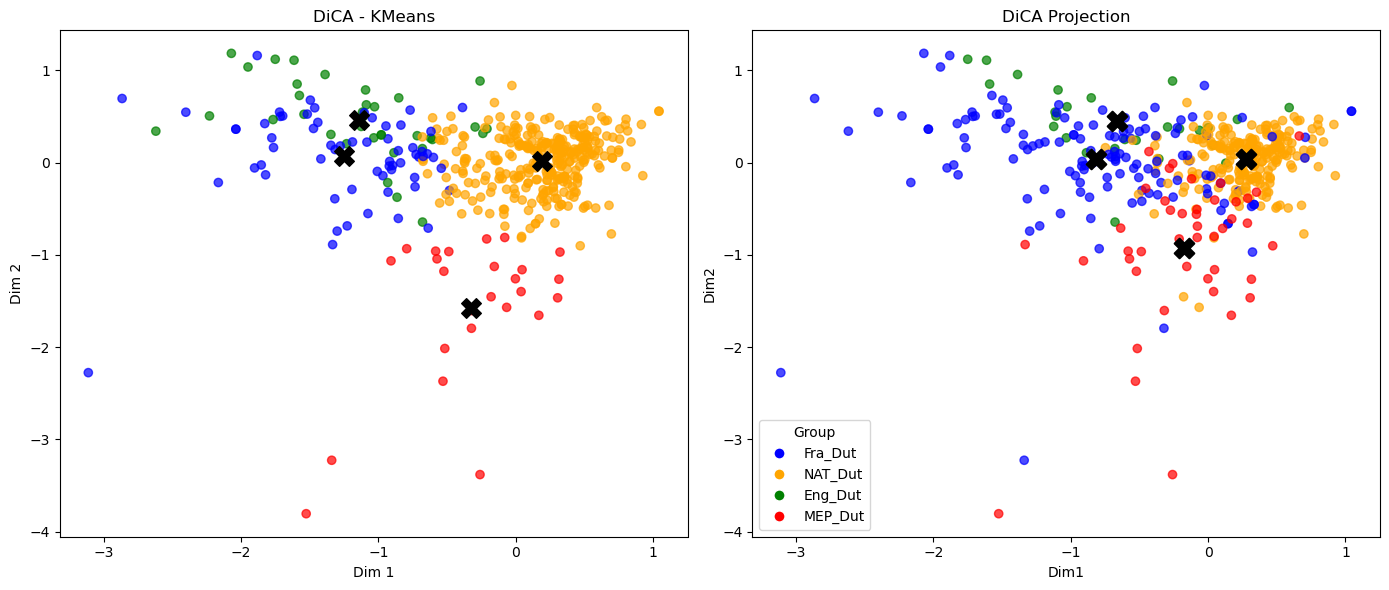

In [11]:
# Number of clusters
n_clusters = 4

# Fit KMeans on DiCA
kmeans_DiCA = KMeans(n_clusters=n_clusters, random_state=42)
data_DiCA['kmeans_cluster'] = kmeans_DiCA.fit_predict(data_DiCA[['Dim1', 'Dim2', 'Dim3', 'Dim4']])

results_DiCA["KMeans"] = {
    "cost": kmeans_DiCA.inertia_,
    "centers": kmeans_DiCA.cluster_centers_,
    "labels": data_DiCA['kmeans_cluster'].values
    
}

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.sca(axs[0])
plot_clusters(data_DiCA_coords, results_DiCA["KMeans"]["labels"],
                 title="DiCA - KMeans", centers=results_DiCA["KMeans"]["centers"])

plot_dica_projection(axs[1], data=data_DiCA)

plt.tight_layout()
plt.show()


# Apply PSO, ABC & ACOR

In [8]:
n_clusters = 4
iters = 1000
n_particles = 50

In [58]:
# Run PSO, ABC, and ACOR on DiCA data
start = time.time()
pso_cost_DiCA, pso_centers_DiCA, pso_labels_DiCA, pso_sil_DiCA, pso_pos_history_DiCA, pso_cost_history_DiCA = SI.run_pso(
    data_DiCA_coords, n_clusters, iters//5, n_particles, record_history=True
)
results_DiCA["PSO"] = {
    "cost": pso_cost_DiCA,
    "silhouette": pso_sil_DiCA,
    "centers": pso_centers_DiCA,
    "labels": pso_labels_DiCA,
}
print("PSO run time on DiCA: {:.2f} seconds".format(time.time() - start))

start = time.time()
abc_cost_DiCA, abc_centers_DiCA, abc_labels_DiCA, abc_history_DiCA = SI.run_abc(
    data_DiCA_coords, n_clusters, iters, n_food_sources=30, limit=20, record_history=True
)
results_DiCA["ABC"] = {
    "cost": abc_cost_DiCA,
    "centers": abc_centers_DiCA,
    "labels": abc_labels_DiCA
}
print("ABC run time on DiCA: {:.2f} seconds".format(time.time() - start))

start = time.time()
acor_cost_DiCA, acor_centers_DiCA, acor_labels_DiCA, acor_history_DiCA = SI.run_acor(
    data_DiCA_coords, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)
results_DiCA["ACOR"] = {
    "cost": acor_cost_DiCA,
    "centers": acor_centers_DiCA,
    "labels": acor_labels_DiCA
}
print("ACOR run time on DiCA: {:.2f} seconds".format(time.time() - start))


PSO run time on DiCA: 3.22 seconds
ABC run time on DiCA: 5.95 seconds
ACOR run time on DiCA: 5.97 seconds


# Compare all techniques

Custom plot functions in order colour each group consistently

In [54]:
label_to_color_fixed = {
    'Fra_Dut': 'blue',
    'NAT_Dut': 'orange',
    'Eng_Dut': 'green',
    'MEP_Dut': 'red'
}

def plot_clusters(data, labels, title, centers=None,
                  x_label="Dim 1", y_label="Dim 2", 
                  label_to_color=label_to_color_fixed, alpha=0.7, 
                  center_color='black', center_marker='X', center_size=200):

    if label_to_color is None:
        unique_labels = sorted(set(labels))
        default_colors = ['blue', 'orange', 'green', 'red']
        label_to_color = {label: default_colors[i % len(default_colors)] for i, label in enumerate(unique_labels)}

    point_colors = [label_to_color[label] for label in labels]

    plt.scatter(data[:, 0], data[:, 1], c=point_colors, alpha=alpha)

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], 
                    c=center_color, 
                    s=center_size, 
                    marker=center_marker, 
                    edgecolors='black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

def plot_dica_projection(ax, data, 
                         label_to_color=label_to_color_fixed, alpha=0.7, 
                         center_color='black', center_marker='X', center_size=200,
                         title="DiCA Ground Truth", x_label="Dim1", y_label="Dim2"):
    
    if label_to_color is None:
        unique_labels = sorted(data['lang4'].unique())
        default_colors = ['blue', 'orange', 'green', 'red']
        label_to_color = {label: default_colors[i % len(default_colors)] for i, label in enumerate(unique_labels)}

    # Plot points
    point_colors = data['lang4'].map(label_to_color)
    scatter = ax.scatter(data['Dim1'], data['Dim2'], 
                         c=point_colors, 
                         alpha=alpha)

    # Plot centroids
    unique_labels = sorted(data['lang4'].unique())
    for label in unique_labels:
        group = data[data['lang4'] == label]
        centroid = group[['Dim1', 'Dim2']].mean().values
        ax.scatter(centroid[0], centroid[1], 
                   color=center_color, 
                   marker=center_marker, 
                   s=center_size,
                   edgecolors='black',
                   linewidths=1.5)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Legend
    handles = [plt.Line2D([], [], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=8)
               for label, color in label_to_color.items()]
    ax.legend(handles=handles, title='Group')


Finding the correct label to number mapping for each technique

In [55]:
labels = ["Fra_Dut", "NAT_Dut", "Eng_Dut", "MEP_Dut"]
numbers = [0, 1, 2, 3]

all_possible_mappings = [
    dict(zip(perm, labels)) for perm in itertools.permutations(numbers)
]

def evaluate_clustering(data, labels, prediction):
    best_scores = (0, 0, 0)
    best_mapping = None

    for mapping in all_possible_mappings:
        mapped_pred = np.vectorize(mapping.get)(prediction)
        acc_score, rand_score, sil_score = SI.evaluate_labels(data, labels, mapped_pred)
        if acc_score > best_scores[0]:
            best_scores = (acc_score, rand_score, sil_score)
            best_mapping = mapping

    return best_scores, best_mapping

Visualize all the methods

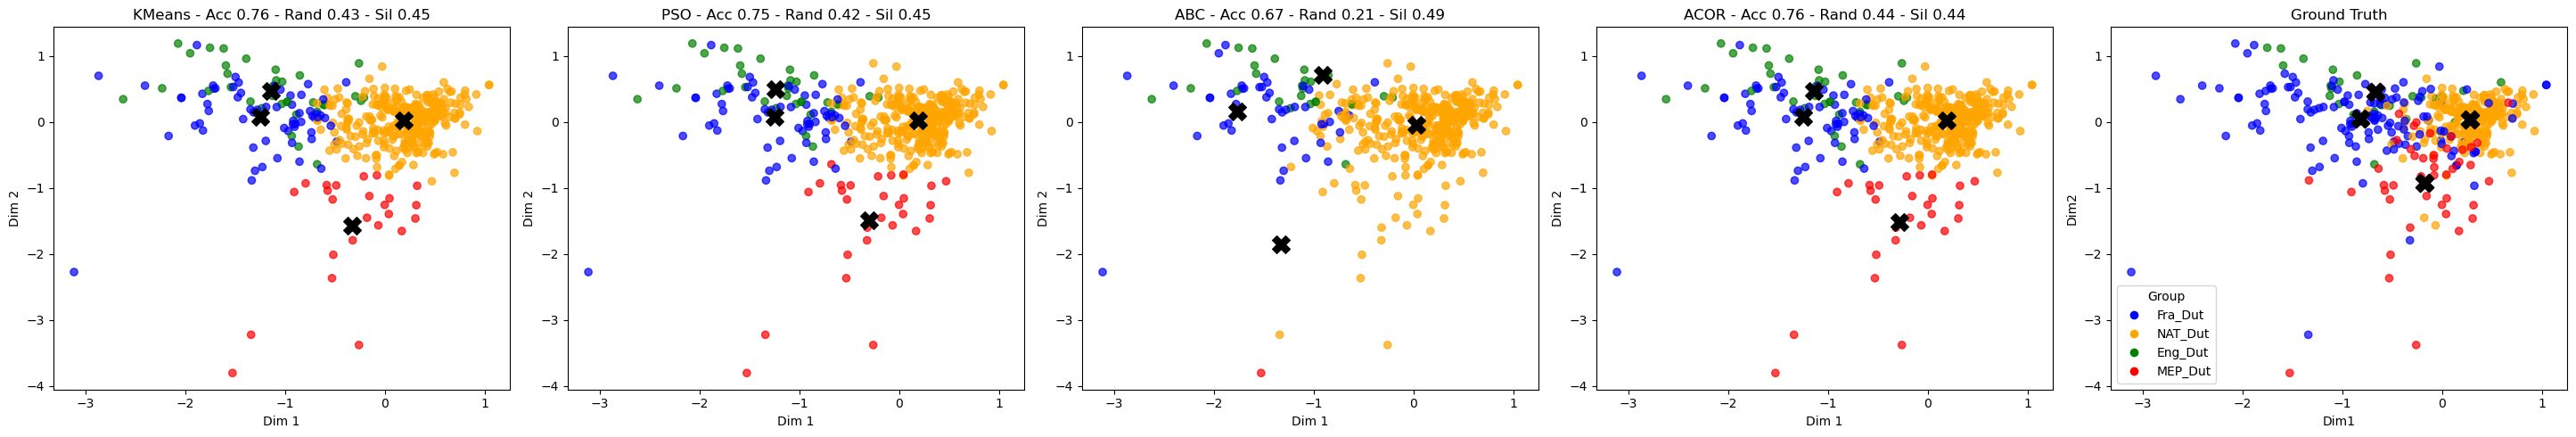

In [62]:
# -------------------------------
# Visualization of Clustering Results - DiCA
# -------------------------------

# get the best mapping for each method
best_mappings = {}
for method in ["KMeans", "PSO", "ABC", "ACOR"]:
    best_scores, best_mapping = evaluate_clustering(data_DiCA_coords, data_DiCA['lang4'].values, results_DiCA[method]["labels"])
    best_mappings[method] = {
        "best_scores": best_scores,
        "best_scores_title": f"{method} - Acc {best_scores[0]:.2f} - Rand {best_scores[1]:.2f} - Sil {best_scores[2]:.2f}",
        "best_mapping": best_mapping
    }


fig, axs = plt.subplots(1, 5, figsize=(29, 5))

# --- DiCA Results ---
for i, method in enumerate(["KMeans", "PSO", "ABC", "ACOR"]):
    plt.sca(axs[i])
    # Plot the best mapping
    mapped_labels = np.vectorize(best_mappings[method]["best_mapping"].get)(results_DiCA[method]["labels"])
    plot_clusters(data_DiCA_coords, mapped_labels,
                  title=best_mappings[method]["best_scores_title"], 
                  centers=results_DiCA[method]["centers"])

plt.sca(axs[4])
plot_dica_projection(axs[4], data=data_DiCA, 
                     title="Ground Truth", x_label="Dim1", y_label="Dim2")
plt.tight_layout()
plt.show()

